# **ICS5110 - Gradient Boosting Implementation**

## **Introduction to Gradient Boosting**

Gradient Boosting is an ensemble learning model, which integrates multiple steps together and transforming them into a single model, in order to produce its own predictions. This type of model utilises a boosting approach, which sequentially combines these steps, which are commonly in the form of decision trees, and turn them into a more improved tree. These trees are also known as weak learners, with each one learning from the mistakes made by their predecessors, thus resulting in a stronger model [1, 2].

## **Suitability of Gradient Boosting to Traffic Accident Prediction**

Literature suggests that gradient boosting is a highly effective solution for predicting traffic accidents, due to a number of reasons. The main resson why it is suitable for this task is that it is able to capture complex patterns which are found in accident data [1, 2]. Additionally, after sufficient preprocessing and hyperparameter fine-tuning, it can be made robust to outliers [3]. Due to their flexibility, it can be used for both classification and regression tasks, which makes it suitable for the appropriate task carried out [1, 2]. Finally, the feature importance that is provided by the model after it is trained allows interpretability of the generated predicitons, which enables further insights into road safety [3].

In [1]:
# ONLY USED IN COLAB

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing packages

In [2]:
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, roc_curve, RocCurveDisplay, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer

## **Loading the cleaned dataset**

In [3]:
#df = pd.read_csv('/content/drive/MyDrive/cleaned_dataset.csv') COLAB ONLY
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,id,source_name,title,author_name,publish_date,accident_date,content,tags,day_of_the_week,time,...,senior_driver_involved,child_involved,senior_involved,visibility,wind_speed,temperature,severity,ambulance_called,additional_source_name,additional_url
0,1.0,police,Collision between a car and a motorbike in Żur...,NaN,09/10/2025,09/10/2025,"Today, at around 0930hrs, the Police were info...",{},Thursday,morning,...,1.0,0.0,1.0,10.0,3.7,23.0,high,1.0,Weatherspark,https://weatherspark.com
1,2.0,police,Car-motorcycle traffic accident,NaN,19/06/2025,18/06/2025,"Yesterday, at around 1830hrs, the Police were ...",{},Wednesday,evening,...,1.0,0.0,1.0,10.0,11.1,26.0,high,1.0,NaN,NaN
2,3.0,police,Car-motorcycle collision in Ħal Qormi,NaN,12/05/2025,12/05/2025,"Today, at around 0800hrs, the Police were info...",{},Monday,morning,...,0.0,0.0,0.0,10.0,27.8,20.0,high,1.0,NaN,NaN
3,4.0,police,Collision between motorcycle and car in Għaxaq,NaN,30/07/2025,29/07/2025,"Yesterday, at around 1800hrs, the Police were ...",{},Tuesday,evening,...,0.0,0.0,0.0,10.0,38.9,26.0,high,1.0,NaN,NaN
4,5.0,police,Car-motorcycle collision,NaN,07/04/2025,06/04/2025,"Yesterday, at around quarter to nine in the ev...",{},Sunday,evening,...,0.0,0.0,0.0,10.0,18.5,15.0,high,1.0,NaN,NaN


In [4]:
df["severity"] = df["severity"].str.lower().str.strip()
df["vehicle_involved"] = df["vehicle_involved"].str.lower().str.strip()

# Binary Encoding the severity -> fatal
df["fatal"] = df["severity"].apply(
    lambda x: 1 if x in ["fatal"] else 0
)

df.head()

,id,source_name,title,author_name,publish_date,accident_date,content,tags,day_of_the_week,time,...,child_involved,senior_involved,visibility,wind_speed,temperature,severity,ambulance_called,additional_source_name,additional_url,fatal
0,1.0,police,Collision between a car and a motorbike in Żur...,NaN,09/10/2025,09/10/2025,"Today, at around 0930hrs, the Police were info...",{},Thursday,morning,...,0.0,1.0,10.0,3.7,23.0,high,1.0,Weatherspark,https://weatherspark.com,0
1,2.0,police,Car-motorcycle traffic accident,NaN,19/06/2025,18/06/2025,"Yesterday, at around 1830hrs, the Police were ...",{},Wednesday,evening,...,0.0,1.0,10.0,11.1,26.0,high,1.0,NaN,NaN,0
2,3.0,police,Car-motorcycle collision in Ħal Qormi,NaN,12/05/2025,12/05/2025,"Today, at around 0800hrs, the Police were info...",{},Monday,morning,...,0.0,0.0,10.0,27.8,20.0,high,1.0,NaN,NaN,0
3,4.0,police,Collision between motorcycle and car in Għaxaq,NaN,30/07/2025,29/07/2025,"Yesterday, at around 1800hrs, the Police were ...",{},Tuesday,evening,...,0.0,0.0,10.0,38.9,26.0,high,1.0,NaN,NaN,0
4,5.0,police,Car-motorcycle collision,NaN,07/04/2025,06/04/2025,"Yesterday, at around quarter to nine in the ev...",{},Sunday,evening,...,0.0,0.0,10.0,18.5,15.0,high,1.0,NaN,NaN,0


In [5]:
features = [
    "vehicle_involved",
    "vehicle_count",
    "road_type",
    "total_driver_count",
    "min_age",
    "max_age",
    "young_driver_involved",
    "adult_driver_involved",
    "senior_driver_involved",
    "child_involved",
    "senior_involved",
    "visibility",
    "wind_speed",
    "temperature",
    "time_in_hours",
    "rush_hour",
    "weekend_weekday"
]

X = df[features]
y = df["fatal"]

In [ ]:
# Distinguish between categorical and numeric features
categorical = ["vehicle_involved", "road_type", "weekend_weekday"]
numeric = [c for c in features if c not in categorical]

# Building the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
        ]), categorical),

        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), numeric)
    ]
)

## **Model Creation & Building**

In [ ]:
# Initalising a Gradient Boosting model
gb_model = GradientBoostingClassifier()

In [ ]:
# Building the pipeline for the model (preprocessing, SMOTE and gradient boosting model)
pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)), #used to balacnce samples when data is imbalanced
    ("gradboost", gb_model)
])

### Hyperparameter tuning with Grid Search and Cross-Validation

In [ ]:
param_grid = {
    'gradboost__n_estimators': [10, 25, 50, 100, 200],
    'gradboost__learning_rate': [0.1, 0.01, 0.001],
    'gradboost__max_depth': [None] + [i for i in range(1, 15)],
    'gradboost__min_samples_split': [2, 5, 10],
    #'subsample': [0.5, 0.7, 0.8, 1.0],
    'gradboost__min_samples_leaf': [1, 2, 4],
    #'max_features': [None, 'sqrt', 'log2']
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=stratified_kfold, scoring='f1', n_jobs=-1)

### Training model

In [8]:
# Splitting the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
# Necessary code to hide any unwanted warnings
import warnings
warnings.filterwarnings('ignore')

# Training the finished model
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['vehicle_involved',
                                                                          'road_type',
                                                                          'weekend_weekday']),
                                                                        ('num',
                                                                         Pipelin...
                                                                          'rush_hour'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('gradboost',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradboost__learning_rate': [0.1, 0.01, 0.001],
                         'gradboost__max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8,
                                                  9, 10, 11, 12, 13, 14],
                         'gradboost__min_samples_leaf': [1, 2, 4],
                         'gradboost__min_samples_split': [2, 5, 10],
                         'gradboost__n_estimators': [10, 25, 50, 100, 200]},
             scoring='f1')

In [11]:
#best_model = model.named_steps["gradboost"].best_estimator_
best_model = model.best_estimator_
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['vehicle_involved',
                                                   'road_type',
                                                   'weekend_weekday']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['vehicle_count',
                                                   'total_driver_count',
                                                   'min_age', 'max_age',
                                                   'young_driver_involved',
                                                   'adult_driver_involved',
                                                   'senior_driver_involved',
                                                   'child_involved',
                                                   'senior_involved',
                                                   'visibility', 'wind_speed',
                                                   'temperature',
                                                   'time_in_hours',
                                                   'rush_hour'])])),
                ('smote', SMOTE(random_state=42)),
                ('gradboost',
                 GradientBoostingClassifier(max_depth=4, n_estimators=200))])

In [9]:
print("Best parameters found: ", model.best_params_)
print("Best cross-validation score: ", model.best_score_)
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Best parameters found:  {'gradboost__learning_rate': 0.1, 'gradboost__max_depth': 4, 'gradboost__min_samples_leaf': 1, 'gradboost__min_samples_split': 2, 'gradboost__n_estimators': 200}
Best cross-validation score:  0.4603174603174603
Test Accuracy: 42.86%


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
#print("Best parameters found: ", model.named_steps["gradboost"].best_params_)
#print("Best cross-validation score: ", model.named_steps["gradboost"].best_score_)
#test_accuracy = model.score(X_test, y_test)
#print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score:  0.9556628621597894
Test Accuracy: 92.68%


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [6]:
import pickle

# Loading the saved model
with open('grad_boost_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [ ]:
import pickle

# Saving the tuned model for future reference
with open('grad_boost_model.pkl', 'wb') as file:
    pickle.dump(model, file)

## Model Testing & Evaluation

In [12]:
y_pred = best_model.predict(X_test) #grid_search.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test) #grid_search.predict_proba(X_test)

print(y_pred)

cm = confusion_matrix(y_test, y_pred)

#print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
#print(f'Precision: {precision_score(y_test, y_pred)}')
#print(f'Recall: {recall_score(y_test, y_pred)}')
#print(f'F1 Score: {f1_score(y_test, y_pred)}')

# Printing the classification report (featuring accuracy, precision, recall and F1-score)
print(classification_report(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))

#coef = model.named_steps["gradboost"].best_estimator_.feature_importances_
coef = best_model.named_steps["gradboost"].feature_importances_
#feature_names = model.named_steps["preprocess"].get_feature_names_out()
feature_names = best_model.named_steps["preprocess"].get_feature_names_out()

print(coef)

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
}).sort_values("Coefficient", ascending=False)

#vehicle_factors = coef_df[coef_df["Feature"].str.startswith("cat__vehicle_involved")]
#print(vehicle_factors)

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        73
           1       0.60      0.33      0.43         9

    accuracy                           0.90        82
   macro avg       0.76      0.65      0.69        82
weighted avg       0.89      0.90      0.89        82

[8.15239711e-06 0.00000000e+00 4.16229400e-03 0.00000000e+00
 1.09400637e-02 0.00000000e+00 0.00000000e+00 8.84100669e-02
 1.09974594e-02 2.73175510e-04 5.28762578e-02 0.00000000e+00
 7.73562705e-03 0.00000000e+00 3.71538456e-06 6.90592051e-02
 9.31830169e-04 8.80618602e-03 0.00000000e+00 5.34382382e-05
 4.06643424e-04 0.00000000e+00 3.60667692e-07 1.10554124e-02
 0.00000000e+00 1.04794620e-06 1.07474217e-04 1.75177896e-01
 3.74774719e-02 4.29120183e-07 9.00674496e-03 1.51075788e-02
 1.46157660e-03 3

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


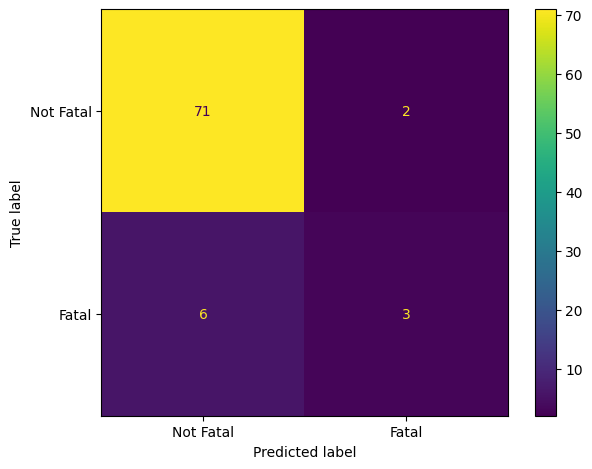

In [13]:
# Displaying the confusion matrix from the results

labels = ['Not Fatal', 'Fatal']

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot()  # Optional: add color for better visualization
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

                                        Feature Coefficient
42                             num__temperature    0.187469
27                     cat__road_type_main road    0.175178
34                                 num__max_age    0.104885
7                 cat__vehicle_involved_car-car    0.088410
15             cat__vehicle_involved_motorcycle    0.069059
43                           num__time_in_hours    0.060709
10         cat__vehicle_involved_car-motorcycle    0.052876
28                   cat__road_type_residential    0.037477
36                   num__adult_driver_involved    0.034418
33                                 num__min_age    0.032413
35                   num__young_driver_involved    0.028658
41                              num__wind_speed    0.026938
31                           num__vehicle_count    0.015108
44                               num__rush_hour    0.013993
23                cat__vehicle_involved_van-bus    0.011055
8         cat__vehicle_involved_car-car-

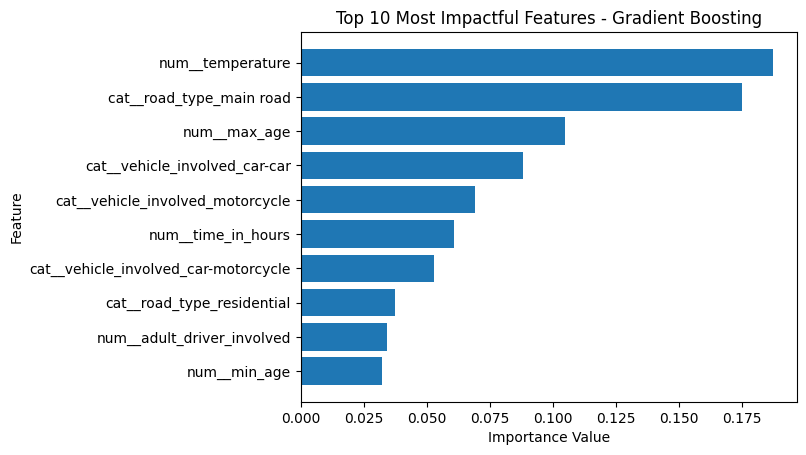

In [14]:
coef_df['Coefficient'] = coef_df['Coefficient'].astype(float)

# Display with specific float format to remove exponential notation
# Using to_string with formatters to control display without global setting changes
print(coef_df.to_string(formatters={'Coefficient': '{:.6f}'.format}))

filtered_coef_df = coef_df.head(10).sort_values('Coefficient')

x_plot = filtered_coef_df["Feature"]
y_plot = filtered_coef_df["Coefficient"]

plt.barh(x_plot, y_plot)
plt.xlabel('Importance Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Impactful Features - Gradient Boosting')
#plt.tight_layout()
plt.show()

In [20]:
# Reviewing the actual and predicted values for each set of features
for i in range(len(X_test)): # Changed from len(X) to len(X_test)
    print(f"\nSample {i+1}")
    print(X_test.iloc[i].to_dict()) # Changed from X.iloc[i] to X_test.iloc[i]
    print("Prediction:", "Fatal" if y_pred[i] == 1 else "Not Fatal")
    print("Probabilities:", y_pred_proba[i])
    print("Actual:", "Fatal" if y_test.iloc[i] == 1 else "Not Fatal")
    #print("Probabilities:", y_test.iloc)


Sample 1
{'vehicle_involved': 'car', 'vehicle_count': 1.0, 'road_type': 'main road', 'total_driver_count': 1.0, 'min_age': 25.0, 'max_age': 28.0, 'young_driver_involved': 0.0, 'adult_driver_involved': 1.0, 'senior_driver_involved': 0.0, 'child_involved': 0.0, 'senior_involved': 0.0, 'visibility': 10.0, 'wind_speed': 18.5, 'temperature': 14.0, 'time_in_hours': 1530, 'rush_hour': 0, 'weekend_weekday': 'weekday'}
Prediction: Not Fatal
Probabilities: [0.95613067 0.04386933]
Actual: Not Fatal

Sample 2
{'vehicle_involved': 'car-motorcycle', 'vehicle_count': 2.0, 'road_type': 'bypass', 'total_driver_count': 2.0, 'min_age': 33.0, 'max_age': 55.0, 'young_driver_involved': 0.0, 'adult_driver_involved': 2.0, 'senior_driver_involved': 0.0, 'child_involved': 0.0, 'senior_involved': 0.0, 'visibility': 10.0, 'wind_speed': 14.8, 'temperature': 29.0, 'time_in_hours': 1515, 'rush_hour': 0, 'weekend_weekday': 'weekday'}
Prediction: Not Fatal
Probabilities: [0.99499091 0.00500909]
Actual: Not Fatal

Sam

## P-R and ROC Curve drawing

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


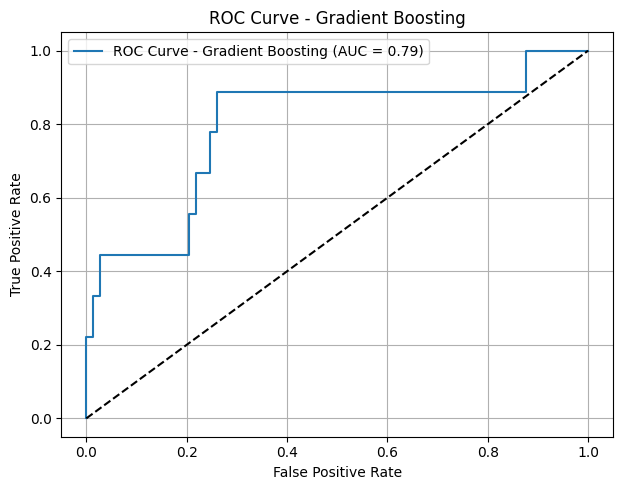

In [21]:
#y_score = model.predict_proba(X_test)[:, 1]
y_score = best_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve - Gradient Boosting (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Gradient Boosting')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


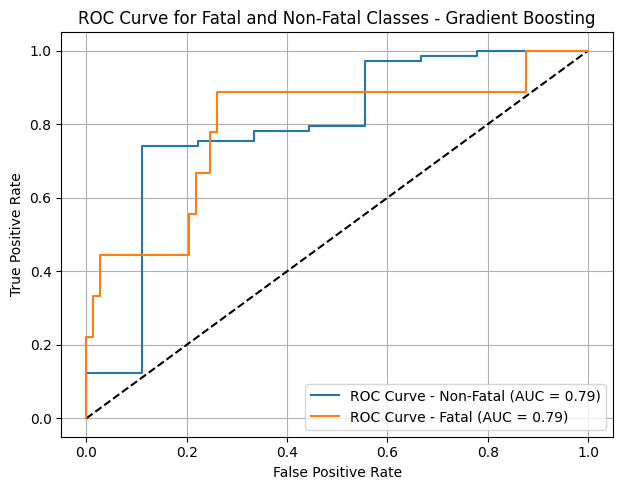

In [22]:
# ROC Curve for Individual Classes
fpr_fatal, tpr_fatal, _ = roc_curve(y_test, y_score, pos_label=1)
fpr_not_fatal, tpr_not_fatal, _ = roc_curve(y_test, y_score, pos_label=0)

#y_pred_proba_rf = best_model.predict_proba(X_test)
y_pred_proba_rf = model.predict_proba(X_test)
y_prob_rf = y_pred_proba_rf[:, 1]

plt.figure(figsize=(12, 5))

# Initialize dictionaries to store ROC curve metrics for each class
fpr_list = dict()
tpr_list = dict()
roc_auc_list = dict()

# Calculate ROC curve and AUC for each class
for i in range(2):  # Assuming binary classification with classes 0 and 1
    fpr_list[i], tpr_list[i], _ = roc_curve(y_test == i, y_pred_proba_rf[:, i])
    roc_auc_list[i] = auc(fpr_list[i], tpr_list[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Fatal and Non-Fatal Classes - Gradient Boosting')
for i in range(2):  # Two classes: 0 and 1
    plt.plot(fpr_list[i], tpr_list[i], label=f'ROC Curve - {"Fatal" if i==1 else "Non-Fatal"} (AUC = {roc_auc_list[i]:0.2f})')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

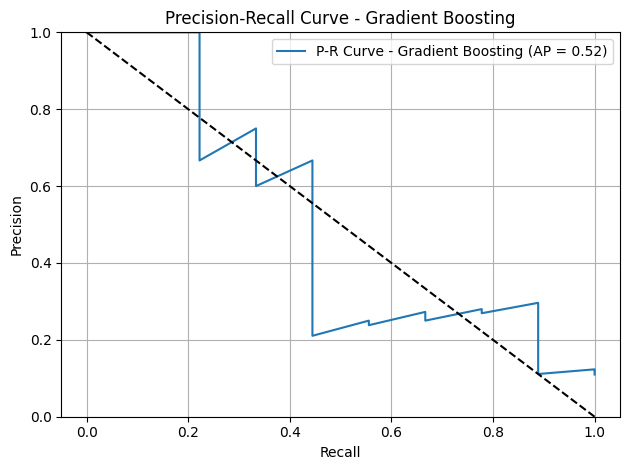

In [23]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

#plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'P-R Curve - Gradient Boosting (AP = {ap:.2f})')
plt.plot([1, 0], [0, 1], 'k--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - Gradient Boosting')
plt.legend()
plt.ylim(0.0, 1.0)
plt.grid(True)

plt.tight_layout()
plt.show()

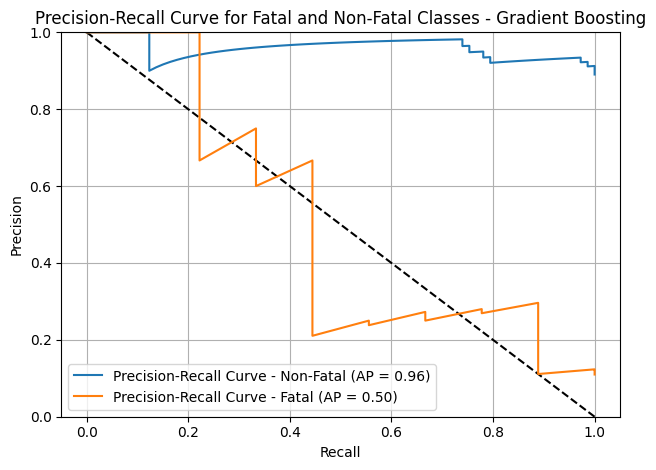

In [24]:
# Precision-Recall Curve for Fatal and Non-Fatal Classes
precision_list = dict()
recall_list = dict()
average_precision_list = dict()

# Calculate Precision-Recall curves for each class
for i in range(2):  # Assuming binary classification with classes 0 and 1
    precision_list[i], recall_list[i], _ = precision_recall_curve(y_test == i, y_pred_proba_rf[:, i])
    average_precision_list[i] = auc(recall_list[i], precision_list[i])

#plt.subplot(1, 2, 2)
plt.plot([1, 0], [0, 1], 'k--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for Fatal and Non-Fatal Classes - Gradient Boosting')
for i in range(2):  # Two classes: 0 and 1
    plt.plot(recall_list[i], precision_list[i], label=f'Precision-Recall Curve - {"Fatal" if i==1 else "Non-Fatal"} (AP = {average_precision_list[i]:0.2f})')
plt.legend()
plt.ylim(0.0, 1.0)
plt.grid(True)

plt.tight_layout()
plt.show()

## **Interpretation**

The feature importance provided above by the model signifies that there are several factors which had a high probability of leading to fatal traffic accidents. Some of these factors include:

- Weather conditions - In particular, both temperature and wind speed often had a high influence in the final prediciton. On the other hand, visibility only had little influence in the final outcome made by the model. Despite this, it signifies that changes in weather play a huge role in the severity of traffic accidents.
- The combination of vehicles involved - Most of the predictions are heavily influenced whenever a small vehicle is involved in a given accident (i.e. bicycle, motorcycle), especially when it is involved with a larger vehicle (e.g. car-motorcycle, van-motorcycle). Additionally, any accidents which involve a single vehicle and a pedestrian also played a role in the decision-making of the model.
- Lighting conditions - While visibility was found to have little influence in the model's predictions, as mentioned above, the time of the day mattered a lot more. In fact, most of the accidents that were considered to be "Fatal" by the model occurred whenever the said accident occurred during the evening or night. This shows that improvements in lighting need to be made to minimize any risk of such accidents in the future.
- Road type - Similar to weather conditions, the type of road in which the accident occurs plays a huge role in influencing the model's predictions, with main roads and residential areas being the most influential. This signifies that measures in these areas need to be taken to reduce the likelihood of accidents occurring in these areas.

Overall, while Gradient Boosting is not fully interpretable, the ability to extract feature importance and review the model's predictions make it easier to explain the model's predictions.

## **Limitations & Ethical Considerations**

While the gradient boosting model found above has been found to perform quite well, it did come with several limitations:

- The vast majority of the accidents found in the dataset were not found to be fatal, which suggested that there was a level of bias made towards the non-fatal class, thus affecting the quality of the results generated.
- Gradient Boosting, similar to other Ensemble Learning techniques, is found to be less interpretable than other linear approaches [3]. The feature importance which is extracted by the model does not imply causation. Therefore, other interpretability techniques, such as SHAP [4], need to be integrated alongside the model to provide full explainability of the results.

There are also some ethical considerations that need to be kept in mind:

- Data privacy must be adhered to at all times, especially when planning to utilise accident data from public sources.
- The predictions generated by the model should be used to guide any decision-making processes, such as making improvements to minimize the risk of future traffic accidents, rather than to replace human judgement. They also should not be used to penalise specific areas or locations without providing the proper context.
- Transparency is required when making decisions regarding road safety or policy.

## **References**

[1] B. Clark and F. Lee, “What is gradient boosting?,” IBM, https://www.ibm.com/think/topics/gradient-boosting (accessed Jan. 7, 2026).

[2] C. Bentéjac, A. Csörgő, and G. Martínez-Muñoz, “A comparative analysis of gradient boosting algorithms,” Artif Intell Rev, vol. 54, no. 3, pp. 1937–1967, Mar. 2021, doi: 10.1007/s10462-020-09896-5.

[3] A. Natekin and A. Knoll, “Gradient boosting machines, a tutorial,” Front. Neurorobot., vol. 7, Dec. 2013, doi: 10.3389/fnbot.2013.00021.

[4] S. Dong et al., “Predicting and Analyzing Road Traffic Injury Severity Using Boosting-Based Ensemble Learning Models with SHAPley Additive exPlanations,” International Journal of Environmental Research and Public Health, vol. 19, no. 5, Mar. 2022, doi: 10.3390/ijerph19052925.